In [1]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

## Load Data

In [2]:
# Load OME-Zarr volumes
raw_z = zarr.open_group('sub-25/micr/sub-25_sample-contra_acq-HM_SEM.ome.zarr', mode='r')
myelin_z = zarr.open_group('derivatives/labels/sub-25/micr/sub-25_sample-contra_acq-HM_desc-myelin_seg.ome.zarr', mode='r')
axon_z = zarr.open_group('derivatives/labels/sub-25/micr/sub-25_sample-contra_acq-HM_desc-axonInstances_dseg.ome.zarr', mode='r')

# Access highest resolution
raw = raw_z['0']
myelin = myelin_z['0']
axons = axon_z['0']

print(f"Raw SEM: {raw.shape} ({raw.dtype})")
print(f"Myelin: {myelin.shape} ({myelin.dtype})")
print(f"Axons: {axons.shape} ({axons.dtype})")
print(f"\nVoxel size: 8 × 8 × 8 nm³")

Raw SEM: (285, 1048, 1042) (uint8)
Myelin: (1042, 1048, 285) (uint8)
Axons: (1042, 1048, 285) (uint16)

Voxel size: 8 × 8 × 8 nm³


## Interactive Slice Viewer

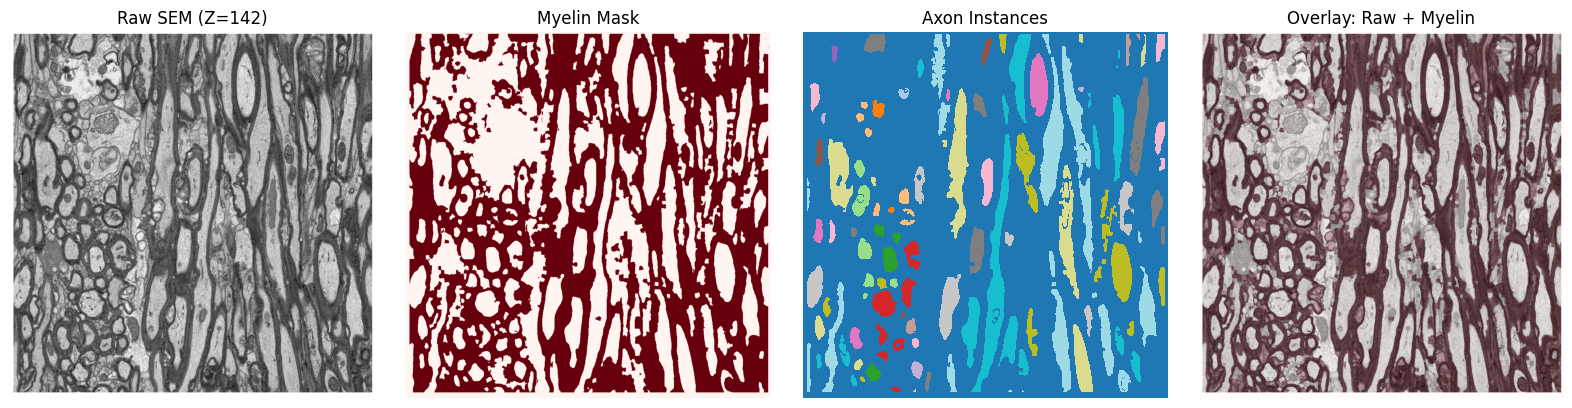

In [6]:
# View a specific slice with overlay
z_slice = 142

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Raw SEM
axes[0].imshow(raw[z_slice, :, :], cmap='gray')
axes[0].set_title(f'Raw SEM (Z={z_slice})')
axes[0].axis('off')

# Myelin mask (transpose to match)
myelin_slice = myelin[:, :, z_slice].T
axes[1].imshow(myelin_slice, cmap='Reds')
axes[1].set_title('Myelin Mask')
axes[1].axis('off')

# Axon instances
axon_slice = axons[:, :, z_slice].T
axes[2].imshow(axon_slice, cmap='tab20', interpolation='nearest')
axes[2].set_title('Axon Instances')
axes[2].axis('off')

# Overlay
axes[3].imshow(raw[z_slice, :, :], cmap='gray')
axes[3].imshow(myelin_slice, cmap='Reds', alpha=0.3)
axes[3].set_title('Overlay: Raw + Myelin')
axes[3].axis('off')

plt.tight_layout()
plt.show()

## Statistics

In [3]:
# Analyze a subset to avoid loading full volume
z_mid = raw.shape[0] // 2
sample_slice = z_mid

# Get one slice
raw_slice = raw[sample_slice, :, :]
myelin_slice = myelin[:, :, sample_slice]
axon_slice = axons[:, :, sample_slice]

print("=" * 50)
print(f"Statistics for slice Z={sample_slice}")
print("=" * 50)

print(f"\nRaw SEM:")
print(f"  Min: {raw_slice.min()}, Max: {raw_slice.max()}")
print(f"  Mean: {raw_slice.mean():.2f}, Std: {raw_slice.std():.2f}")

print(f"\nMyelin Coverage:")
myelin_coverage = (myelin_slice > 0).sum() / myelin_slice.size * 100
print(f"  {myelin_coverage:.2f}% of pixels")

print(f"\nAxon Instances:")
unique_axons = len(np.unique(axon_slice[axon_slice > 0]))
print(f"  {unique_axons} axons in this slice")
print(f"  Total unique instances in volume: {len(np.unique(axons[:][axons[:] > 0]))}")

Statistics for slice Z=142

Raw SEM:
  Min: 0, Max: 255
  Mean: 134.12, Std: 56.49

Myelin Coverage:
  51.53% of pixels

Axon Instances:
  103 axons in this slice
  Total unique instances in volume: 367


## Histogram Analysis

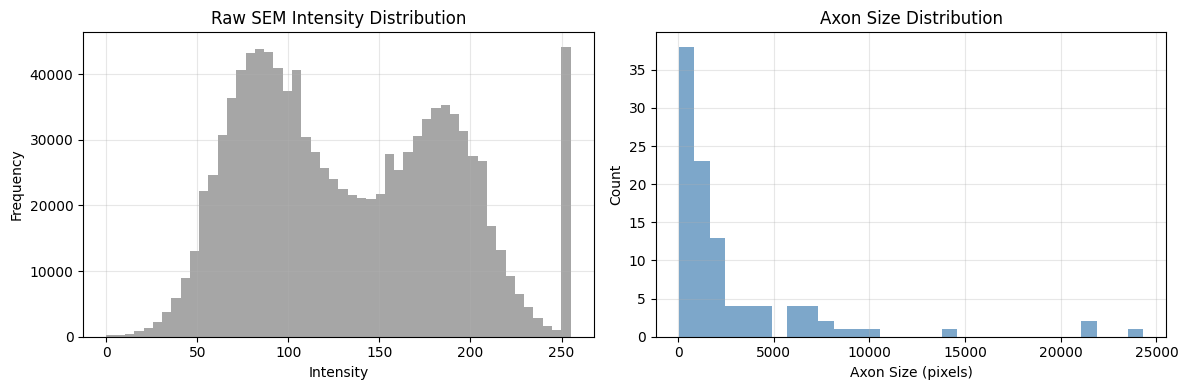

Axon sizes: min=42, max=24309, mean=2835.4


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Intensity histogram
axes[0].hist(raw_slice.ravel(), bins=50, color='gray', alpha=0.7)
axes[0].set_xlabel('Intensity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Raw SEM Intensity Distribution')
axes[0].grid(alpha=0.3)

# Axon size distribution (for this slice)
from scipy import ndimage
unique_labels = np.unique(axon_slice[axon_slice > 0])
sizes = [np.sum(axon_slice == label) for label in unique_labels]

axes[1].hist(sizes, bins=30, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Axon Size (pixels)')
axes[1].set_ylabel('Count')
axes[1].set_title('Axon Size Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Axon sizes: min={min(sizes)}, max={max(sizes)}, mean={np.mean(sizes):.1f}")

## 3D Rendering Preview

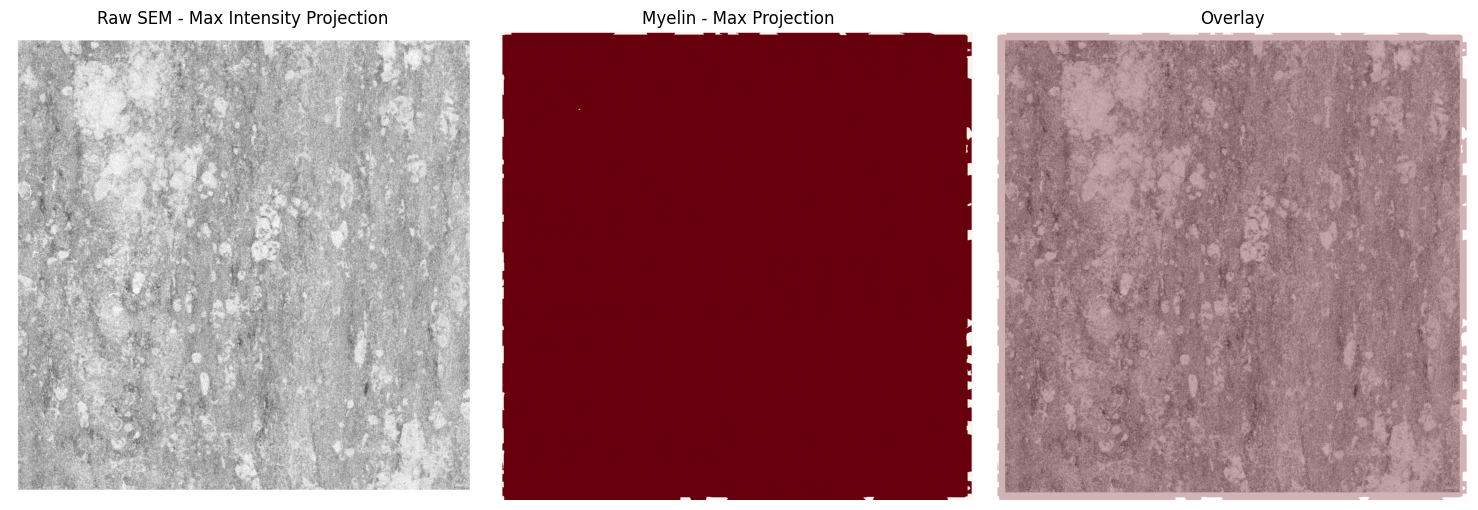

In [5]:
# Maximum intensity projection along Z axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Load subset for MIP (every 10th slice to save memory)
subset_raw = raw[::10, :, :]
subset_myelin = myelin[:, :, ::10]

axes[0].imshow(np.max(subset_raw, axis=0), cmap='gray')
axes[0].set_title('Raw SEM - Max Intensity Projection')
axes[0].axis('off')

axes[1].imshow(np.max(subset_myelin, axis=2), cmap='Reds')
axes[1].set_title('Myelin - Max Projection')
axes[1].axis('off')

# Overlay
axes[2].imshow(np.max(subset_raw, axis=0), cmap='gray')
axes[2].imshow(np.max(subset_myelin, axis=2), cmap='Reds', alpha=0.3)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Launch Napari (Optional)

For full 3D interactive visualization, uncomment and run:

In [ ]:
# import napari
# viewer = napari.Viewer()
# viewer.add_image(raw[:], name='Raw SEM', colormap='gray', scale=[0.008, 0.008, 0.008])
# viewer.add_labels(np.transpose(myelin[:], (2, 0, 1)), name='Myelin', scale=[0.008, 0.008, 0.008])
# viewer.add_labels(np.transpose(axons[:], (2, 0, 1)), name='Axons', scale=[0.008, 0.008, 0.008])